In [11]:
# !!! Results from train_and_predict and grid_search get outputted to a file !!!
# Import essential libraries.

import pandas as pd 
import sklearn.model_selection
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [15]:
df

,biome,GO:0000502,GO:0001510,GO:0003950,GO:0003968,GO:0004037,GO:0004114,GO:0004122,GO:0004144,GO:0004352,...,sk__Bacteria;k__;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Arcobacter,sk__Bacteria;k__;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema_porcinum,sk__Bacteria;k__;p__Tenericutes;c__Mollicutes,sk__Bacteria;k__;p__Verrucomicrobia;c__Spartobacteria;o__Chthoniobacterales;f__Chthoniobacteraceae;g__Candidatus_Udaeobacter,sk__Bacteria;k__;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia,sk__Eukaryota;k__;p__;c__Dinophyceae;o__Suessiales;f__Symbiodiniaceae;g__Symbiodinium,sk__Eukaryota;k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Eurotiales;f__Aspergillaceae,sk__Eukaryota;k__Fungi;p__Basidiomycota;c__Ustilaginomycetes;o__Ustilaginales;f__Ustilaginaceae,sk__Eukaryota;k__Metazoa;p__Annelida;c__Polychaeta;o__Terebellida,sk__Eukaryota;k__Metazoa;p__Arthropoda;c__Ostracoda;o__Halocyprida
0,root:Host-associated:Plants,0.0,1.0,5.0,11.0,2.0,0.0,0.0,9.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,root:Host-associated:Human:Digestive system,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,root:Host-associated:Human:Digestive system,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,root:Host-associated:Human:Digestive system,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,root:Host-associated:Human:Digestive system,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18498,root:Engineered:Wastewater:Activated Sludge,2.0,1.0,0.0,1.0,3.0,0.0,2.0,7.0,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18499,root:Engineered:Wastewater:Activated Sludge,0.0,6.0,0.0,0.0,4.0,1.0,2.0,15.0,55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18502,root:Engineered:Bioreactor,0.0,31.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18503,root:Host-associated:Plants,2.0,1.0,6.0,24.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Load the dataset from a pickle file.
df: pd.DataFrame = pd.read_pickle('data.pkl')

In [14]:
# Filter out only columns defined as important from .tsv file
important_features = [ col.split(' ')[0] 
    for col 
    in pd.read_csv('important.tsv', sep='\t').columns
]
df = df[['biome', *important_features[1:]]]

In [16]:
# Replace all NA values with 0.0.
df.replace(pd.NA, 0.0, inplace=False)

# Add a new derived column sum_all - sum of all numeric columns (feature values).
df['sum_all'] = df.sum(axis=1, numeric_only=True)

# Filter out rows with sum_all <= 0.0 - no feature was found in the sample.
df = df[df['sum_all'] > 0.0]

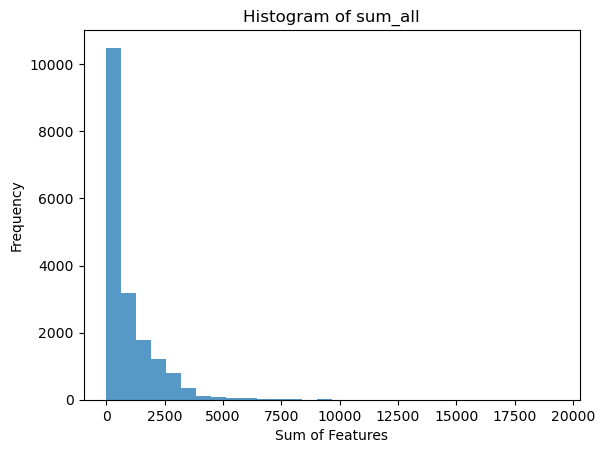

In [17]:
# Histogram of the sum_all feature
plt.hist(df['sum_all'], bins=30, alpha=0.75)
plt.title('Histogram of sum_all')
plt.xlabel('Sum of Features')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Frequency')

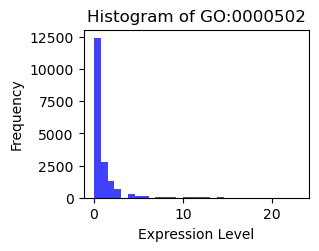

In [18]:
# Histogram for GO:0000502
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
plt.hist(df['GO:0000502'], bins=30, alpha=0.75, color='blue')
plt.title('Histogram of GO:0000502')
plt.xlabel('Expression Level')
plt.ylabel('Frequency')


Text(0, 0.5, 'Frequency')

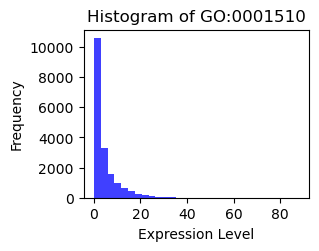

In [21]:
# Histogram for GO:0001510
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
plt.hist(df['GO:0001510'], bins=30, alpha=0.75, color='blue')
plt.title('Histogram of GO:0001510')
plt.xlabel('Expression Level')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

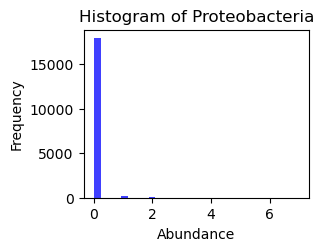

In [24]:
# Histogram for Proteobacteria
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, 3rd subplot
plt.hist(df['sk__Bacteria;k__;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Arcobacter'], bins=30, alpha=0.75, color='blue')
plt.title('Histogram of Proteobacteria')
plt.xlabel('Abundance')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

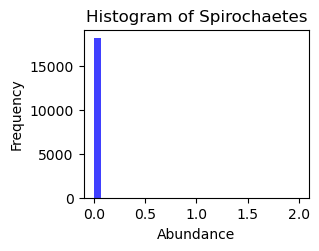

In [26]:
# Histogram for Spirochaetes
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, 4th subplot
plt.hist(df['sk__Bacteria;k__;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema_porcinum'], bins=30, alpha=0.75, color='blue')
plt.title('Histogram of Spirochaetes')
plt.xlabel('Abundance')
plt.ylabel('Frequency')

In [27]:
# Split the dataset into training and testing subsets for model validation.
target = df['biome']
features = df.drop(columns=['biome'])

X_train: pd.DataFrame
X_test: pd.DataFrame
y_train: pd.DataFrame
y_test: pd.DataFrame

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, 
                                                             target,
                                                             test_size=0.2,
                                                             random_state=69420) # type: ignore

In [8]:
# Utility class to wrap a classifier with.
# Implements model fitting, prediction and evaluation in method `train_and_predict`
# and GridSearchCV in method `grid_search`.


class Model:
    def __init__(self, classifier, grid_search_params):
        self._classifier = classifier
        self._grid_search_params = grid_search_params

    def train_and_predict(self, 
                          X_train: pd.DataFrame,
                          X_test: pd.DataFrame,
                          y_train: pd.DataFrame,
                          y_test: pd.DataFrame):
        
        self._classifier.fit(X=X_train, y=y_train)
        y_predict = self._classifier.predict(X=X_test)

        file_name = self._get_name() + '-classification_report.txt'
        with open(file_name, 'w') as f:
            f.write(str(classification_report(y_test, y_predict)))

    def _get_name(self) -> str:
        return self._classifier.__class__.__name__.lower()

    def grid_search(self, **kwargs):
        print(f'Performing grid search on {self._get_name()}...')
        grid_search = sklearn.model_selection.GridSearchCV(
            self._classifier, 
            self._grid_search_params, 
            **kwargs,
        )

        grid_search.fit(X_train, y_train)
        file_name = self._get_name() + '-grid_search.txt'

        with open(file_name, 'w') as f:
            f.write(str(grid_search.best_params_))



In [9]:
# Support Vector Machines classifier with grid search parameters.
svm = Model(SVC(), { 
    'C': [0.5, 1], 
    'kernel': ['rbf'],
})

In [ ]:
# Fit, predict and evaluate using support vector machines.
# Note: this takes quite long (~5 minutes on a modern CPU).
svm.train_and_predict(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

In [ ]:
# This takes even longer, 
# wasn't even able to finish with the few grid search parameters defined
# (when run on 8 out of 16 threads on R7 4800H, the CPU overheated after 6 minutes :))
svm.grid_search(n_jobs=6)

In [10]:
# A simpler - decision tree classifier with grid search parameters.
# From GridSearchCV: criterion='log_loss', splitter='best'.
tree = Model(DecisionTreeClassifier(criterion='log_loss', splitter='best'), {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
})

In [ ]:
# Grid search on the tree classifier.
tree.grid_search(n_jobs=6)

In [11]:
# Fit, predict and evaluate the tree classifier.
tree.train_and_predict(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)